## Elevating User Experience: Enhanced Post Classification for Personalized Content Discovery in ‘MakeupAddiction’ Subreddit

Business Goal: 

    Navigating the enormous ocean of social media content, users frequently encounter difficulties in promptly locating content that corresponds to their interests. Our aim is to enhance the user experience on the "MakeupAddiction" subreddit through the development of a sophisticated system for classifying posts. Our objective is to enhance community engagement, optimize content discovery, and achieve this by accurately classifying posts according to their content, user interaction, and other relevant metadata. It is anticipated that this endeavor will result in increased user contentment, longer platform sessions, and improved user retention through the presentation of a more structured and personalized content environment.
    
Technical Proposal:

    It is possible to make a supervised machine learning model that is great at accurately classifying posts by using a mix of textual and metadata features, like post titles, content, user interaction data, and other relevant subreddit metadata. In order to efficiently process textual information, the model will be trained utilizing natural language processing (NLP) techniques, including TF-IDF and word embeddings. It will subsequently be assessed using standardized classification metrics. Once the performance of the classifier has been optimized, it will be incorporated into the infrastructure of the subreddit along with a feedback mechanism that ensures the model is continually enhanced in response to user input.



### Spark Setup and Data Preparation

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [3]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [4]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "32G") \
    .config("spark.executor.memory", "16G") \
    .config("spark.executor.memoryOverhead", "4G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3afb1557-a309-4d5d-93bb-f25b21b726cd;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [5]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
#remove null tag
submissions = submissions.filter(submissions.link_flair_text.isNotNull())
print(f"shape of the comments dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-032393624300/project/submissions/yyyy=*


23/12/07 07:58:32 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/12/07 07:58:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the comments dataframe is 59,459x68
CPU times: user 2.97 s, sys: 145 ms, total: 3.11 s
Wall time: 3min 23s


### Data Preprocessing

In [7]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_
from pyspark.ml.feature import StringIndexer



In [8]:
# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("link_flair_text") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# Finisher
finisher = Finisher() \
    .setInputCols(["normalized"])

# Pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher
])

# Apply the pipeline
processed_tags_df = nlp_pipeline.fit(submissions).transform(submissions)




In [9]:
# Text Processing for Title and Selftext (Body)

# Document Assemblers for title and selftext
title_assembler = DocumentAssembler().setInputCol("title").setOutputCol("title_document")
selftext_assembler = DocumentAssembler().setInputCol("selftext").setOutputCol("selftext_document")

# Tokenizers for title and selftext
title_tokenizer = Tokenizer().setInputCols(["title_document"]).setOutputCol("title_token")
selftext_tokenizer = Tokenizer().setInputCols(["selftext_document"]).setOutputCol("selftext_token")

# Normalizers for title and selftext
title_normalizer = Normalizer().setInputCols(["title_token"]).setOutputCol("title_normalized").setLowercase(True)
selftext_normalizer = Normalizer().setInputCols(["selftext_token"]).setOutputCol("selftext_normalized").setLowercase(True)

# Finishers for title and selftext
title_finisher = Finisher().setInputCols(["title_normalized"]).setOutputCols(["finished_title_normalized"]).setOutputAsArray(True)
selftext_finisher = Finisher().setInputCols(["selftext_normalized"]).setOutputCols(["finished_selftext_normalized"]).setOutputAsArray(True)


# Extended NLP Pipeline
extended_nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher,
    title_assembler,
    title_tokenizer,
    title_normalizer,
    title_finisher,
    selftext_assembler,
    selftext_tokenizer,
    selftext_normalizer,
    selftext_finisher
])

# Apply the extended pipeline
extended_processed_df = extended_nlp_pipeline.fit(submissions).transform(submissions)

In [10]:
from pyspark.ml.feature import CountVectorizer

# CountVectorizer for each text feature
cv_text = CountVectorizer(inputCol="finished_normalized", outputCol="cv_text_features")
cv_title = CountVectorizer(inputCol="finished_title_normalized", outputCol="cv_title_features")
cv_selftext = CountVectorizer(inputCol="finished_selftext_normalized", outputCol="cv_selftext_features")

# Fitting and transforming
model_text = cv_text.fit(extended_processed_df)
model_title = cv_title.fit(extended_processed_df)
model_selftext = cv_selftext.fit(extended_processed_df)

df_with_features = model_text.transform(extended_processed_df)
df_with_features = model_title.transform(df_with_features)
df_with_features = model_selftext.transform(df_with_features)



In [11]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Prepare the Label Column with handling invalid values
label_indexer = StringIndexer(inputCol="link_flair_text", outputCol="label", handleInvalid="keep")
df_with_features = label_indexer.fit(df_with_features).transform(df_with_features)

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=["cv_text_features", "cv_title_features", "cv_selftext_features"], outputCol="features")
final_prepared_df = assembler.transform(df_with_features)

# Continue with the model training
training_data, testing_data = final_prepared_df.randomSplit([0.6, 0.4], seed=42)

### Train the data (Random Forest)

In [10]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Train the Random Forest model
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [11]:
model = rf_classifier.fit(training_data)
# Make Predictions
predictions = model.transform(testing_data)

23/12/06 21:27:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/12/06 21:27:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/12/06 21:31:12 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/12/06 21:34:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/12/06 21:38:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
23/12/06 21:38:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/06 21:38:51 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/12/06 21:39:02 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


In [12]:
# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [13]:
# Evaluate accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print(f"Model Accuracy: {accuracy}")

23/12/06 21:39:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Model Accuracy: 0.4471981853314291


In [14]:
# Evaluate precision
precision = evaluator.setMetricName("precisionByLabel").evaluate(predictions)
print(f"Model Precision: {precision}")

23/12/06 21:42:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Model Precision: 0.44403810171797925


In [15]:
# Evaluate recall
recall = evaluator.setMetricName("recallByLabel").evaluate(predictions)
print(f"Model Recall: {recall}")

23/12/06 21:46:02 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Model Recall: 0.9981837300449288


In [16]:
# Evaluate F1 score
f1 = evaluator.setMetricName("f1").evaluate(predictions)
print(f"Model F1 Score: {f1}")

23/12/06 21:49:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Model F1 Score: 0.28663903325315054


In [17]:
# Path where the model will be saved
model_path = "../../data/models/random_forest_classification"

# Save the trained Random Forest model
model.save(model_path)

### Train the data(Logistic Regression)

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize and train the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(training_data)
# Make predictions
lrPredictions = lrModel.transform(testing_data)

23/12/07 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:23:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:23:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/07 08:23:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:26:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:26:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:01 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:27 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/07 08:27:32 WARN DAGSchedul

In [13]:
# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [14]:
lrAccuracy = evaluator.setMetricName("accuracy").evaluate(lrPredictions)
lrPrecision = evaluator.setMetricName("precisionByLabel").evaluate(lrPredictions)
lrRecall = evaluator.setMetricName("recallByLabel").evaluate(lrPredictions)
lrF1 = evaluator.setMetricName("f1").evaluate(lrPredictions)

print(f"Logistic Regression Model Accuracy: {lrAccuracy}")
print(f"Logistic Regression Model Precision: {lrPrecision}")
print(f"Logistic Regression Model Recall: {lrRecall}")
print(f"Logistic Regression Model F1 Score: {lrF1}")

23/12/07 08:42:40 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB
23/12/07 08:46:12 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB
23/12/07 08:49:18 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB
23/12/07 08:52:21 WARN DAGScheduler: Broadcasting large task binary with size 41.2 MiB


Logistic Regression Model Accuracy: 0.9625677365568988
Logistic Regression Model Precision: 0.9899815988550399
Logistic Regression Model Recall: 0.9442277691107644
Logistic Regression Model F1 Score: 0.9648262181571903


In [21]:
from pyspark.ml.classification import LogisticRegressionModel

# Path where the model will be saved
model_path = "../../data/models/best_logistic_regression_model"

# Save the trained Logistic Regression model with overwrite
lrModel.write().overwrite().save(model_path)


23/12/07 09:00:37 WARN TaskSetManager: Stage 171 contains a task of very large size (40207 KiB). The maximum recommended task size is 1000 KiB.


### Train the data (Naive Bayes)

In [18]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize and train the Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='label')
nbModel = nb.fit(training_data)
# Make predictions
nbPredictions = nbModel.transform(testing_data)



23/12/06 21:52:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/06 21:55:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


In [19]:
# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")


In [20]:
# Evaluate accuracy, precision, recall, and F1 score
nbAccuracy = evaluator.setMetricName("accuracy").evaluate(nbPredictions)


23/12/06 21:55:50 WARN DAGScheduler: Broadcasting large task binary with size 63.7 MiB
23/12/06 21:56:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [21]:
nbPrecision = evaluator.setMetricName("precisionByLabel").evaluate(nbPredictions)


23/12/06 21:59:01 WARN DAGScheduler: Broadcasting large task binary with size 63.7 MiB


In [22]:
nbRecall = evaluator.setMetricName("recallByLabel").evaluate(nbPredictions)


23/12/06 22:02:24 WARN DAGScheduler: Broadcasting large task binary with size 63.7 MiB


In [23]:
nbF1 = evaluator.setMetricName("f1").evaluate(nbPredictions)


23/12/06 22:05:39 WARN DAGScheduler: Broadcasting large task binary with size 63.7 MiB


In [24]:
print(f"Naive Bayes Model Accuracy: {nbAccuracy}")
print(f"Naive Bayes Model Precision: {nbPrecision}")
print(f"Naive Bayes Model Recall: {nbRecall}")
print(f"Naive Bayes Model F1 Score: {nbF1}")

Naive Bayes Model Accuracy: 0.7541796185835503
Naive Bayes Model Precision: 0.9015639374425023
Naive Bayes Model Recall: 0.7494503393557022
Naive Bayes Model F1 Score: 0.7402795993585033


### Model Comparison

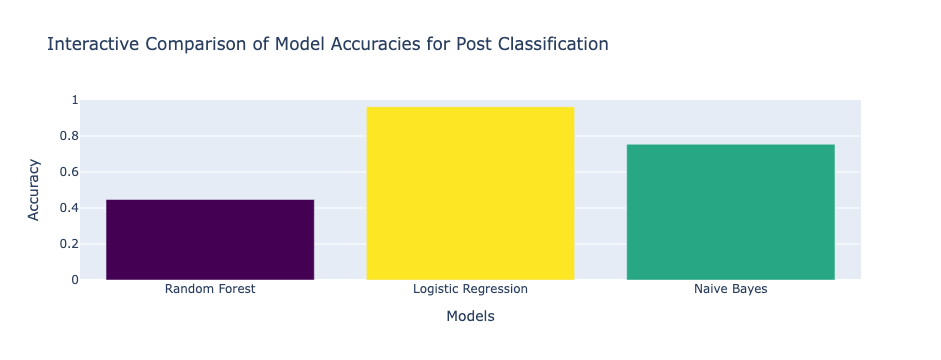

In [36]:
import plotly.express as px

# Model names and their accuracies
models = ['Random Forest', 'Logistic Regression', 'Naive Bayes']
accuracies = [0.4471981853314291, 0.9625677365568988, 0.7541796185835503]

# Creating the interactive bar plot with Plotly
fig = px.bar(
    x=models, 
    y=accuracies, 
    color=accuracies,
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'x': 'Models', 'y': 'Accuracy'},
    title='Interactive Comparison of Model Accuracies for Post Classification'
)

# Enhancing the plot
fig.update_layout(
    xaxis_title='Models',
    yaxis_title='Accuracy',
    yaxis=dict(range=[0, 1]),
    coloraxis_showscale=False
)

# Show the plot
fig.show()


In [37]:
fig.write_html("../../data/plots/ml/title_classification_model_accuracy.html")

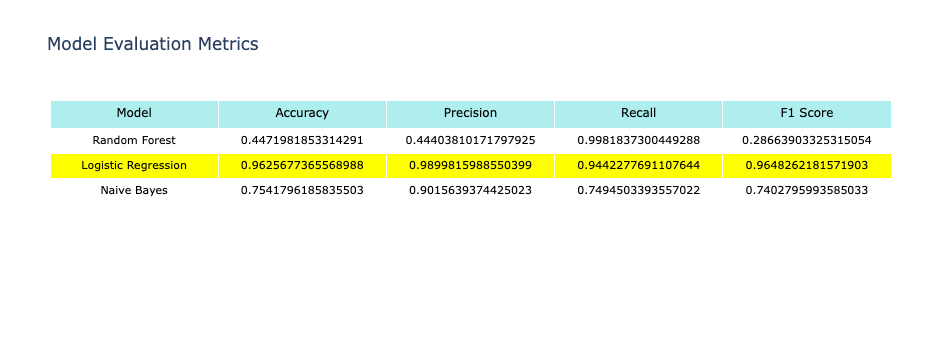

In [32]:
import plotly.graph_objects as go

# Model performance metrics
metrics = {
    "Model": ["Random Forest", "Logistic Regression", "Naive Bayes"],
    "Accuracy": [0.4471981853314291, 0.9625677365568988, 0.7541796185835503],
    "Precision": [0.44403810171797925, 0.9899815988550399, 0.9015639374425023],
    "Recall": [0.9981837300449288, 0.9442277691107644, 0.7494503393557022],
    "F1 Score": [0.28663903325315054, 0.9648262181571903, 0.7402795993585033]
}

# Define colors for each cell
colors = ['lightgrey' if i%2 else 'white' for i in range(len(metrics["Model"]))]

# Custom formatting for Logistic Regression
highlight = 'yellow'
colors[1] = highlight  # Highlight Logistic Regression

# Create table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(metrics.keys()),
                fill_color='paleturquoise',
                align='center',
                font=dict(color='black', size=12)),
    cells=dict(values=[metrics[key] for key in metrics.keys()],
               fill_color=[colors] * len(metrics.keys()),
               align='center',
               font=dict(color='black', size=11),
               height=25)
)])

# Adjust layout to remove extra whitespace
fig.update_layout(
    title="Model Evaluation Metrics",  # Add title
    margin=dict(l=50, r=50, t=100, b=50),  # Remove all margins
    autosize=False,
    width = 1100,
    height=(len(metrics["Model"])+1) * 65  
)

fig.show()



In [33]:
fig.write_html("../../data/plots/ml/title_classification_model_compare_table.html")

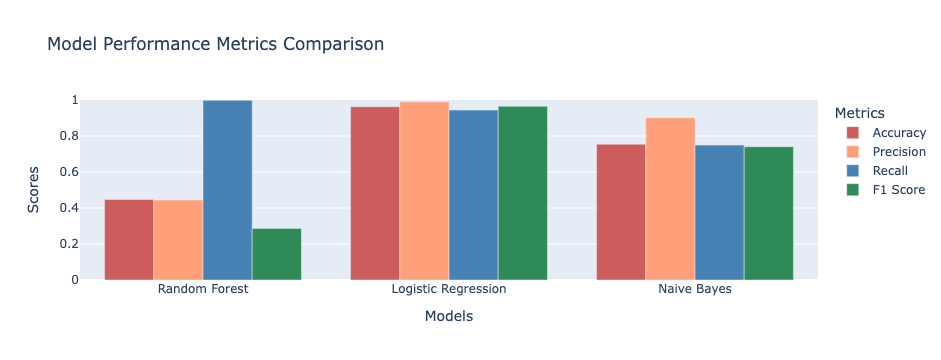

In [34]:
import plotly.graph_objects as go

# Model names and their metrics
models = ['Random Forest', 'Logistic Regression', 'Naive Bayes']
accuracies = [0.4471981853314291, 0.9625677365568988, 0.7541796185835503]
precisions = [0.44403810171797925, 0.9899815988550399, 0.9015639374425023]
recalls = [0.9981837300449288, 0.9442277691107644, 0.7494503393557022]
f1_scores = [0.28663903325315054, 0.9648262181571903, 0.7402795993585033]

# Create subplots to have side by side bar charts
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=models, y=accuracies, marker_color='indianred'),
    go.Bar(name='Precision', x=models, y=precisions, marker_color='lightsalmon'),
    go.Bar(name='Recall', x=models, y=recalls, marker_color='steelblue'),
    go.Bar(name='F1 Score', x=models, y=f1_scores, marker_color='seagreen')
])

# Change the bar mode to group the bars for each model
fig.update_layout(barmode='group')

# Add titles and labels
fig.update_layout(
    title='Model Performance Metrics Comparison',
    xaxis_title='Models',
    yaxis_title='Scores',
    yaxis=dict(range=[0, 1]),  # Assuming all metrics are between 0 and 1
    legend_title='Metrics'
)

# Show figure
fig.show()


In [35]:
fig.write_html("../../data/plots/ml/title_classification_model_compare_bar.html")

Logistic Regression is the most suitable model for this subreddit classification task. Its high accuracy, precision, and recall indicate it can effectively classify posts with minimal errors. This aligns perfectly with the business goal of improving user experience by accurately presenting relevant content. Random Forest, despite its high recall, is less desirable due to low precision and accuracy. Naive Bayes offers a moderate performance but doesn't match the effectiveness of Logistic Regression. Therefore, implementing Logistic Regression would likely enhance user engagement and satisfaction by providing a more accurate, personalized content discovery experience.

### Optimize the Best Performing Model:

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1])  # Regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Elastic Net Parameter
             .build())

# Define evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Set up 5-fold cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(training_data)

# Use model to make predictions
cvPredictions = cvModel.transform(testing_data)

# Evaluate best model
bestModelAccuracy = evaluator.evaluate(cvPredictions)
print(f"Best Model Accuracy: {bestModelAccuracy}")


23/11/25 21:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
23/11/25 21:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1621.5 KiB
23/11/25 21:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1622.2 KiB
23/11/25 21:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB
23/11/25 21:26:33 WAR

Best Model Accuracy: 0.9969924812030075


In [20]:
# Extract the best model from the Cross Validator
bestModel = cvModel.bestModel

# Save the best model, overwriting if the path already exists
bestModel.write().overwrite().save("../../data/model/best_logistic_regression_model")


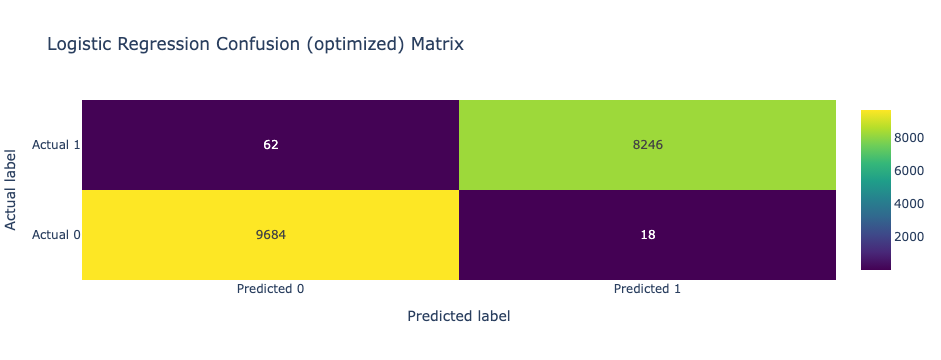

In [28]:
                                                                                
# Collect the true labels and predicted labels
y_true = cvPredictions.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = cvPredictions.select("prediction").rdd.flatMap(lambda x: x).collect()
# For binary classification, collect the probability of the positive class for ROC
y_prob = cvPredictions.select("probability").rdd.map(lambda x: x[0][1]).collect()


                                                                                
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
# Create the confusion matrix heatmap with annotations
fig_cm = go.Figure(data=go.Heatmap(
    z=conf_mat,
    x=["Predicted 0", "Predicted 1"],  
    y=["Actual 0", "Actual 1"],  
    showscale=True,
    colorscale='Viridis',
    text=conf_mat,
    texttemplate="%{text}",
    hoverinfo='none'  # Turns off hover info
))
fig_cm.update_layout(
    title='Logistic Regression Confusion (optimized) Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='Actual label')
)
# Show the confusion matrix plot
fig_cm.show()

The confusion matrix for the tuned Logistic Regression model indicates a strong predictive performance. True Positives are high at 8246, indicating that the model is highly effective at identifying relevant posts. True Negatives are also high at 9684, showing that it accurately recognizes non-relevant posts. With only 18 False Positives, the model rarely misclassifies non-relevant posts as relevant, which is essential for user experience to avoid unnecessary content. False Negatives are relatively low at 62, suggesting that while the model occasionally misses relevant posts, it does so infrequently. Parameter tuning has evidently honed the model's ability to discern between classes, optimizing its classification accuracy for the subreddit content.

In [31]:
fig_cm.write_html("../../data/plots/ml/title_classification_confusion_matrix(refined).html")